# Pynams: A Python Package for Nominally Anhydrous Minerals
Here are some examples for how to process FTIR spectra to estimate hydrogen contents and perform basic diffusion modeling with pynams.  

This software package can also handle profiles of FTIR spectra and sets of three profiles in three orthogonal directions grouped together as 'whole block' objects.  

Here I show only simple examples for spectra and diffusion modeling. For examples of handling profile and whole block data, see my project on [hydrogen diffusion in clinopyroxene](https://github.com/EFerriss/HydrogenCpx) but project was done with an earlier version... so stick to these examples.

## Get pynams and basic python scientific and plotting packages
pynams should work with either python 2.7 or 3 and requires the [lmfit](https://pypi.python.org/pypi/lmfit/).  

For those new to python, I recommend downloading [anaconda](https://www.continuum.io/downloads).If you are used to Matlab, check out [spyder](https://pythonhosted.org/spyder/), which comes with anaconda.To get the latest version of pynams off github, probably the easiest way is to 'clone' it using [GitHub Desktop](https://desktop.github.com/)

First we're going to do some basic imports that you'll understand what they're used for farther on.

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


## Create a spectrum object
The core structure you need to understand to handle FTIR spectra with pynams is a class called Spectrum. So, let's import that.

In [7]:
from pynams import Spectrum

Each of your FTIR spectra will have to be created as an object, and Spectrum is the class, or template, for making these objects. Each Spectrum object then by default has attributes like thickness and the ability to create and save baselines. 

Each FTIR spectrum **requires** a short descriptive name (fname), and the location of the file containing the data (folder).

Ideally also give it information about the sample thickness **in microns** (thickness_microns),  Currently only .CSV and txt files are supported. The spectrum's fname should be the same as the filename without the extension. So if your spectrum is saved as pynamsDemo.CSV, the spectrum's fname should be the string 'pynamsDemo'.

Here in the first line I create a particular spectrum ("instantiate the class Spectrum" in object-oriented parlance), which I call spectrum, and I specify the fname and thickness while creating it.

This spectrum also needs to know where to find data from the file pynamsDemo.CSV. Here, for instance, we'll make a dummy spectrum called test, and it will complain because it can't find the file.

In [12]:
spectrum = Spectrum(fname = 'test')

There is a problem finding the file.
filename = test.CSV
current working directory =  C:\Users\Ferriss\Documents\Code\Pynams\pynams\OtherStuffIWillBringBackLater\examples_and_discussions
Maybe check the folder name


Now, let's go get some data. I'll pull it off the web, but feel free to use your own.

Mac people: Maybe don't include the C: at the beginning of the folder name

In [29]:
# Here is the folder on my personal computer where I'm going to save the file.
FTIR_file_location = 'C:\\Users\\Ferriss\\Documents\\FTIR'

# Here I go get test data from the web and save it to the specified folder. If you have your own data don't bother with this.
import requests
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/P_0_unpol.CSV')
workfile = ''.join((FTIR_file_location,'test.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)

# Now we can make the spectrum. 
spectrum = Spectrum(fname='test', folder=FTIR_file_location, thickness_microns=268.)

## Plotting spectra
You can look at the spectrum by calling the method plot_spectrum. This function returns handles for the figure and axis, which you can then save or adjust as with any other figure generated using matplotlib. To show another spectrum on the same axis, use the argument figaxis. You can also specify the style (my favorites are stored in pynams.styles) and set labels for making legends. 

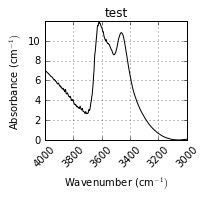

In [31]:
fig, ax = spectrum.plot_spectrum()

Next we'll plot two spectra on top of each other.  



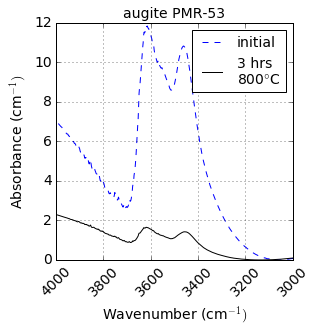

In [49]:
# Making second spectrum called spectrum2 the same way you did above
# get another test file
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/P_6_unpol.CSV')
workfile = ''.join((FTIR_file_location, spectrum2.fname,'.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)
# make the second spectrum    
spectrum2 = Spectrum(fname = 'pynamsDemo2', thickness_microns = 876.4, folder=FTIR_file_location)

# A larger plot with two spectra and a legend
from pynams import styles
fig, ax = spectrum.plot_spectrum(style=styles.style_initial, label='initial')
spectrum2.plot_spectrum(axes=ax, style=styles.style_1, label='3 hrs\n800$\degree$C')
fig.set_size_inches(5, 5)
ax.set_ylim(0, 12.)
ax.set_title('augite PMR-53', fontsize=14)
hleg = ax.legend(loc=1, fontsize=14) 

# change font sizes
plt.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

## Making baselines
The default is a line between wavenumbers 3200 and 3700 cm-1, but you can also make quadratic baselines (linetype='quadratic') or cubic splines (linetype='spline'; these can take awhile to run) and change the wavenumber range. Here are some examples:

Making baseline...


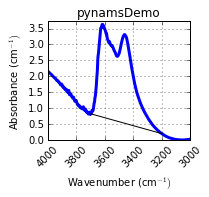

In [6]:
fig, ax = spectrum.plot_showbaseline()

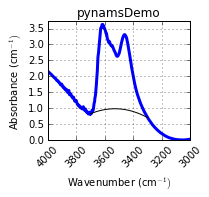

In [7]:
baseline = spectrum.make_baseline(linetype='quadratic', shiftline=-0.2, show_plot=True, wn_low=3300)

fitting x values: [ 3700.789  3450.     3000.744]
fitting y values: [ 0.82493154  0.23779071  0.02341511]


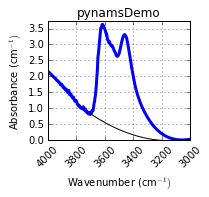

In [8]:
baseline = spectrum.make_baseline(linetype='quadratic', shiftline=0.3, show_plot=False, show_fit_values=True, wn_low=3000)
fig, ax = spectrum.plot_showbaseline()

## Subtracting the baseline

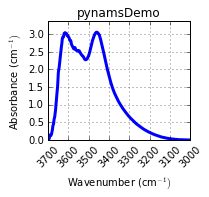

In [9]:
fig, ax = spectrum.plot_subtractbaseline()

## Saving baselines
The method save_baseline() creates a new file fname-baseline.CSV containing the baseline and baseline-subtracted spectrum normalized per cm.

In [10]:
spectrum.save_baseline(folder=FTIR_file_location)

using existing baseline
Saving pynamsDemo-baseline.CSV


## Retrieving saved baseline information

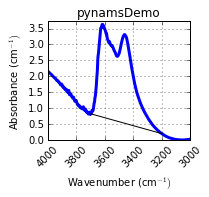

In [11]:
# Get previously generated baseline information from the web
htmlname = 'https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/baselines/P_0_unpol-baseline.CSV'
r = requests.get(htmlname)
workfile = ''.join((FTIR_file_location, spectrum.fname, '-baseline.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)

baseline_data = spectrum.get_baseline(folder=FTIR_file_location)
fig, ax = spectrum.plot_showbaseline()

## Estimating peak area and water concentration
Right now only the mineral-specific area calibrations from Bell et al. 1995 for clinopyroxene (phase_name='cpx') and Bell&Rossman 2003 or Withers et al. 2012 for olivine (phase_name='olivine', calibration='Bell' or 'Withers') are included, but other calibrations (Paterson, wavenumber-specific, other minerals) can be added either by me upon request, or, because the code is open source, by you, dear reader.

For this simple case, the water concentration returned is just the area between the curve and baseline multiplied by the integral specific absorption coefficient, and the error is propogated only from the error on that absorption coefficient. Ideally one would add up these areas from spectra polarized in three orthogonal directions (Libowitzky&Rossman, 1996). 

pynamsDemo
area: 719.1 /cm^2
water: 85.6+/-4.3 ppm H2O; *3 = 256.7+/-12.9 ppm H2O


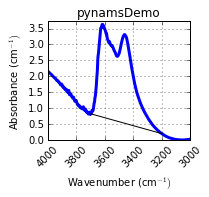

In [12]:
area, water = spectrum.water(phase_name='olivine', show_plot=True, calibration='Withers')

## Peak fitting
I am unfortunately not aware of any good peak fitting programs currently available in python. The peak fitting program that I use is an open-source program available for Matlab and Octave called [peakfit.m](https://terpconnect.umd.edu/~toh/spectrum/InteractivePeakFitter.htm#command). Another option I am aware of is OpticalFit, which was developed by and is available from CSIRO Australia.

My strategy is as follows:  
1. Make and save the baseline using pynams as described above.
2. Perform a peak fitting routine on the baseline-subtracted spectrum in Matlab using peakfit.m, usually called through this [helper function](https://github.com/EFerriss/pynams/blob/master/matlab_helper_files/FTIR_peakfit_loop.m) that loops through spectra fnames and allows setting individual peak widths and heights.
3. At the end of FTIR_peakfit_loop.m call another matlab function to [save the fit](https://github.com/EFerriss/pynams/blob/master/matlab_helper_files/savefit.m) details as fname-peakfit.CSV
4. Back in python, retrieve the saved peakfit information using pynams.Spectrum.get_peakfit()


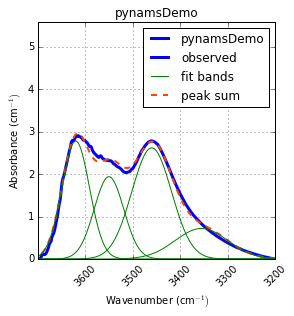

In [13]:
# Get previously generated peakfit information file from the web
r = requests.get('https://raw.githubusercontent.com/EFerriss/HydrogenCpx/master/FTIR_CSV_FILES/peakfits/P_0_unpol-peakfit.CSV')
workfile = ''.join((FTIR_file_location, spectrum.fname, '-peakfit.CSV'))
with open(workfile, 'w') as f:
    f.write(r.content)

fig, ax = spectrum.plot_peakfit()
fig.set_size_inches(5, 5)

# To get the curve information details, use 
peakfitcurves, summed_spectrum = spectrum.get_peakfit()


# Diffusion modeling
## 1-dimensional diffusion

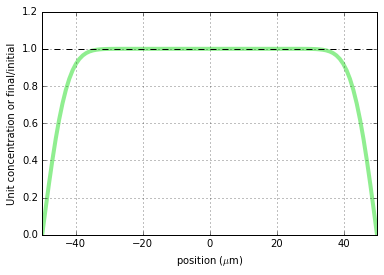

In [14]:
from pynams import diffusion

log10D_m2s = -12.
length_microns = 100.
time_minutes = 1000.

fig, ax, x, y = diffusion.diffusion1D(length_microns, log10D_m2s, time_seconds=time_minutes/60., init=1., fin=0.)

## 3-dimensional, non-path-integrated (3Dnpi) in a rectangular parallelepiped
coming soon!
v is the the 3-dimensional matrix of concentrations in the parallelepiped